<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-12/EVA4_S12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/tree/master/Session-12)

# Google Drive Mount

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

#add working directory into syspath
EVA4_PATH = "/content/gdrive/My Drive/Colab Notebooks/EVA4/Session-12"
import sys
if not EVA4_PATH in sys.path:
  sys.path.append(EVA4_PATH)

# Download Image

In [0]:
#!/usr/bin/python3
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    # Download the file from the URL
zipresp = urlopen(zipurl)
    # Create a new file on the hard drive
tempzip = open("/tmp/tempfile.zip", "wb")
    # Write the contents of the downloaded file into the new file
tempzip.write(zipresp.read())
    # Close the newly-created file
tempzip.close()
    # Re-open the newly-created file with ZipFile()
zf = ZipFile("/tmp/tempfile.zip")
    # Extract its contents into <extraction_path>
    # note that extractall will automatically create the path
zf.extractall(path = '/opt/')
    # close the ZipFile instance
zf.close()

# Python Module Import & device

In [0]:
import utils.data as data
import utils.transform as tf
import model.nn2 as nn2
import utils.torch_util as util
import utils.visualize as view
import utils.runner as network

#device
device = util.device()
print(f"Device: {device}")

Device: cuda


# Read TinyImageNet Data

In [0]:
data_path = f"/opt/tiny-imagenet-200"

# read tinyimagenet data
img_dataset = data.LoadImage(root_path=data_path)
mean, std = util.normalized_mean_std(img_dataset.mean, img_dataset.std)

Total time taken to load image: 25.77 seconds


# Create Train & Test dataset

In [0]:
import torch
torch.manual_seed(6)
torch.cuda.manual_seed(6)

tf_util = tf.torch_transform()
compose_transforms = tf.compose_transforms(tf_util.RandomHorizontalFlip(p=1), tf_util.RandomCrop(size=64, padding=4, padding_mode="edge"), tf_util.ToTensor(), tf_util.Normalize(mean=mean, std=std))
train_dataset = data.ImageDataset(dataset=img_dataset.train_data, labels=img_dataset.train_labels,
                                  transforms=compose_transforms)
test_dataset = data.ImageDataset(dataset=img_dataset.test_data, labels=img_dataset.test_labels,
                                  transforms=compose_transforms)

# Create Train & Test Dataloader

In [0]:
torch.manual_seed(6)
torch.cuda.manual_seed(6)

kwargs = {'pin_memory': True, 'num_workers': 4}
train_loader = data.TinyImageNetDataLoader(dataset=train_dataset, batch_size=500, shuffle=True, **kwargs).dataloader
test_loader = data.TinyImageNetDataLoader(dataset=test_dataset, batch_size=500, shuffle=False, **kwargs).dataloader

# Create Model & Summary

In [0]:
torch.manual_seed(6)
torch.cuda.manual_seed(6)

model = nn2.resnet18(num_classes=200).to(device)
util.model_summary(model=model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

# Load Model state_dict

In [0]:
trained_model_path = util.drive_path(filename="tiny-imagenet-resnet18.pt", folder="Session-12") 
if trained_model_path:
    state_dict = util.load_model(path=trained_model_path)
    model.load_state_dict(state_dict=state_dict)

# Create Optimizer, loss function, Scheduler

In [0]:
# create optimizer, loss fn, scheduler
criterion = util.loss_fns().CrossEntropyLoss()
sgd_optimizer = util.optimizer().SGD(params=model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.1e-5)
# scheduler = util.scheduler().ReduceLROnPlateau(optimizer=sgd_optimizer, mode="min", patience=0, verbose=True,
                                                # min_lr=0.5e-6, factor=0.125)

# Train & Test Run

In [0]:
# train & test
epochs = 50
train_accuracy = []
test_accuracy = []
max_train_accuracy_so_far = 0
max_test_accuracy_so_far = 0
for epoch in range(1, epochs + 1):
    print(f"\nEPOCH: {epoch}")
    train_acc = network.train(model=model, data_loader=train_loader, optimizer=sgd_optimizer, criterion=criterion,
                              device=device)
    test_acc = network.test(model=model, data_loader=test_loader, device=device)
    scheduler.step(100 - test_acc)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    if max_test_accuracy_so_far < test_acc:
        max_test_accuracy_so_far = test_acc
        print(f"\n***Test Accuracy is greater than previous max accuracy. Saving model on epoch: {epoch}")
        util.save_model(model=model, path=trained_model_path)

    #early stopping
    if test_acc >= 50:
      break

  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 1


Batch: 139, loss: 2.55, Train Accuracy: 37.53 [26269/70000]: 100%|██████████| 140/140 [00:22<00:00,  6.32it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 1

EPOCH: 2


Batch: 139, loss: 2.50, Train Accuracy: 41.70 [29188/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.36it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 2

EPOCH: 3


Batch: 139, loss: 2.40, Train Accuracy: 44.91 [31439/70000]: 100%|██████████| 140/140 [00:22<00:00,  6.32it/s]
  0%|          | 0/140 [00:00<?, ?it/s]

Epoch     3: reducing learning rate of group 0 to 1.2500e-03.

EPOCH: 4


Batch: 139, loss: 1.67, Train Accuracy: 55.00 [38497/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.40it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 4

EPOCH: 5


Batch: 139, loss: 1.72, Train Accuracy: 58.47 [40932/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.37it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 5

EPOCH: 6


Batch: 139, loss: 1.53, Train Accuracy: 60.18 [42124/70000]: 100%|██████████| 140/140 [00:22<00:00,  6.27it/s]
  0%|          | 0/140 [00:00<?, ?it/s]

Epoch     6: reducing learning rate of group 0 to 1.5625e-04.

EPOCH: 7


Batch: 139, loss: 1.49, Train Accuracy: 62.01 [43407/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.43it/s]
  0%|          | 0/140 [00:00<?, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.9531e-05.

EPOCH: 8


Batch: 139, loss: 1.65, Train Accuracy: 62.35 [43646/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.41it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 8

EPOCH: 9


Batch: 139, loss: 1.55, Train Accuracy: 62.54 [43776/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.43it/s]
  0%|          | 0/140 [00:00<?, ?it/s]

Epoch     9: reducing learning rate of group 0 to 2.4414e-06.

EPOCH: 10


Batch: 139, loss: 1.60, Train Accuracy: 62.56 [43791/70000]: 100%|██████████| 140/140 [00:22<00:00,  6.34it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 10

EPOCH: 11


Batch: 139, loss: 1.51, Train Accuracy: 62.46 [43723/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.40it/s]
  0%|          | 0/140 [00:00<?, ?it/s]

Epoch    11: reducing learning rate of group 0 to 5.0000e-07.

EPOCH: 12


Batch: 139, loss: 1.53, Train Accuracy: 62.37 [43661/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.46it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 13


Batch: 139, loss: 1.64, Train Accuracy: 62.38 [43666/70000]: 100%|██████████| 140/140 [00:22<00:00,  6.36it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 14


Batch: 139, loss: 1.59, Train Accuracy: 62.64 [43850/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.45it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 15


Batch: 139, loss: 1.55, Train Accuracy: 62.46 [43722/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.44it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 16


Batch: 139, loss: 1.62, Train Accuracy: 62.57 [43800/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.49it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 17


Batch: 139, loss: 1.52, Train Accuracy: 62.58 [43805/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.50it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 18


Batch: 139, loss: 1.53, Train Accuracy: 62.58 [43809/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.49it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 19


Batch: 139, loss: 1.64, Train Accuracy: 62.70 [43889/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.56it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 19

EPOCH: 20


Batch: 139, loss: 1.59, Train Accuracy: 62.42 [43697/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.53it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 21


Batch: 139, loss: 1.55, Train Accuracy: 62.65 [43854/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.58it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 22


Batch: 139, loss: 1.51, Train Accuracy: 62.37 [43656/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.44it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 23


Batch: 139, loss: 1.64, Train Accuracy: 62.69 [43882/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.63it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 24


Batch: 139, loss: 1.56, Train Accuracy: 62.55 [43782/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.58it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 25


Batch: 139, loss: 1.63, Train Accuracy: 62.61 [43827/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.55it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 26


Batch: 139, loss: 1.56, Train Accuracy: 62.43 [43702/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.57it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 27


Batch: 139, loss: 1.62, Train Accuracy: 62.47 [43731/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.47it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 28


Batch: 139, loss: 1.52, Train Accuracy: 62.66 [43861/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.60it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 29


Batch: 139, loss: 1.53, Train Accuracy: 62.65 [43857/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.47it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 30


Batch: 139, loss: 1.49, Train Accuracy: 62.48 [43736/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.50it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 31


Batch: 139, loss: 1.61, Train Accuracy: 62.43 [43704/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.54it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 31

EPOCH: 32


Batch: 139, loss: 1.51, Train Accuracy: 62.42 [43697/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.57it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 33


Batch: 139, loss: 1.56, Train Accuracy: 62.63 [43844/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.58it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 34


Batch: 139, loss: 1.57, Train Accuracy: 62.71 [43898/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.57it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 35


Batch: 139, loss: 1.55, Train Accuracy: 62.40 [43681/70000]: 100%|██████████| 140/140 [00:20<00:00,  6.68it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 36


Batch: 139, loss: 1.48, Train Accuracy: 62.48 [43733/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.59it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 37


Batch: 139, loss: 1.67, Train Accuracy: 62.35 [43647/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.60it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 38


Batch: 139, loss: 1.66, Train Accuracy: 62.62 [43831/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.53it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 39


Batch: 139, loss: 1.61, Train Accuracy: 62.46 [43725/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.49it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 40


Batch: 139, loss: 1.65, Train Accuracy: 62.61 [43825/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.50it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 41


Batch: 139, loss: 1.49, Train Accuracy: 62.53 [43770/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.47it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 42


Batch: 139, loss: 1.70, Train Accuracy: 62.67 [43869/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.51it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 43


Batch: 139, loss: 1.61, Train Accuracy: 62.48 [43739/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.59it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 44


Batch: 139, loss: 1.65, Train Accuracy: 62.56 [43791/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.50it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 45


Batch: 139, loss: 1.51, Train Accuracy: 62.58 [43804/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.53it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 46


Batch: 139, loss: 1.59, Train Accuracy: 62.47 [43732/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.39it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 47


Batch: 139, loss: 1.62, Train Accuracy: 62.64 [43849/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.39it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 47

EPOCH: 48


Batch: 139, loss: 1.67, Train Accuracy: 62.73 [43912/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.57it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 49


Batch: 139, loss: 1.57, Train Accuracy: 62.52 [43766/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.52it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 50


Batch: 139, loss: 1.57, Train Accuracy: 62.87 [44008/70000]: 100%|██████████| 140/140 [00:21<00:00,  6.55it/s]
Batch: 59, Test Accuracy: 28.82: 100%|██████████| 60/60 [00:08<00:00,  7.24it/s]


# Epochs & Train Accuracy

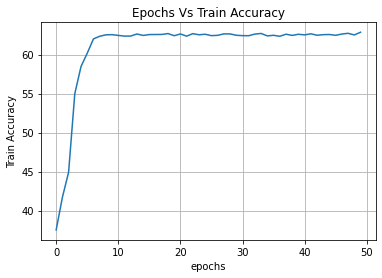

In [0]:
view.show_graph(range(epochs), train_accuracy, "epochs", "Train Accuracy", "Epochs Vs Train Accuracy")

# Epochs & Test Accuracy

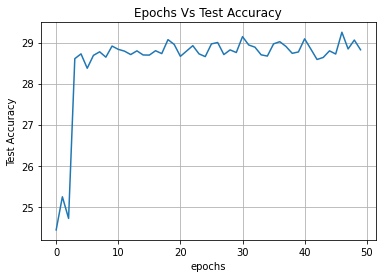

In [0]:
view.show_graph(range(epochs), test_accuracy, "epochs", "Test Accuracy", "Epochs Vs Test Accuracy")